In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('covid-russia.csv')
df.head(3)

,nday,date,total_cases,new_cases
0,0,2020-03-03,3,1
1,1,2020-03-04,4,1
2,2,2020-03-05,4,0


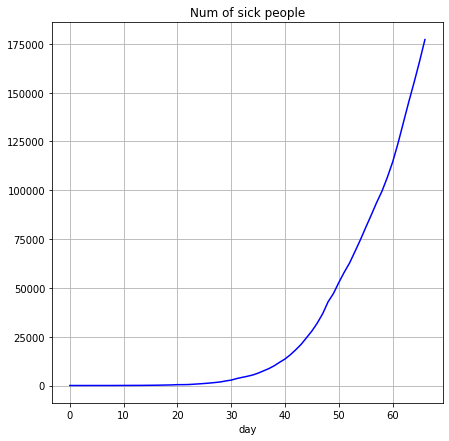

In [3]:
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(df['nday'].values, df['total_cases'].values, color='blue')
ax.set(xlabel='day', title='Num of sick people')
ax.grid()
plt.show()

### Обучим модель с экспоненциальным числом заболевших

$$ y \sim \exp (\alpha \cdot x+\beta) \Leftrightarrow \ln y \sim \alpha \cdot x+\beta$$

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
df['total_cases_log'] = np.log(df['total_cases'])

In [6]:
df['nday'] = df['nday'] + 1

In [7]:
train = df[:50]
test = df[50:]

In [8]:
lr = LinearRegression()
lr.fit(train['nday'].values.reshape(-1, 1), train['total_cases_log'].values)
print("Alpha = %.4f, Beta = %.4f" % (lr.coef_[0], lr.intercept_))

Alpha = 0.2033, Beta = 1.2757


### Воспользуемся Байесовской библиотекой для семплинга Pystan

In [9]:
import pystan

In [19]:
model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;

    int<lower=0> N_new;
    vector[N_new] x_new;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha * x + beta, sigma);
}
generated quantities {
        vector[N_new] y_new;
        y_new = alpha * x_new + beta;      
}
"""

In [20]:
alpha = lr.coef_[0]
beta = lr.intercept_
sigma = 1.0

In [22]:
# Put our data in a dictionary
data = {'N': train.shape[0], 
        'x': train['nday'].values, 
        'y': train['total_cases_log'],
        'N_new': df.shape[0],
        'x_new': df['nday'].values, 
       }

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f586f50cb8b28ab7da2214e5800a983b NOW.
/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2c/ssfd22r166x8hgqvwvgvf6h40000gn/T/tmpvmkkq0hk/stanfit4anon_model_f586f50cb8b28ab7da2214e5800a983b_6467582782891906997.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [16]:
# для проверки, что цепи сошлись
# import stan_utility
# stan_utility.check_all_diagnostics(fit)

In [23]:
print(fit)

Inference for Stan model: anon_model_f586f50cb8b28ab7da2214e5800a983b.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha        0.2  1.3e-4 3.9e-3    0.2    0.2    0.2   0.21   0.21    987    1.0
beta        1.28  3.9e-3   0.12   1.05    1.2   1.27   1.35   1.51    903   1.01
sigma       0.38  1.3e-3   0.04   0.31   0.35   0.37    0.4   0.46    942    1.0
y_new[0]    1.48  3.7e-3   0.11   1.26   1.41   1.48   1.55   1.71    905   1.01
y_new[1]    1.68  3.6e-3   0.11   1.47   1.61   1.68   1.75    1.9    907   1.01
y_new[2]    1.89  3.5e-3   0.11   1.68   1.82   1.88   1.96    2.1    910   1.01
y_new[3]    2.09  3.4e-3    0.1   1.89   2.02   2.09   2.16   2.29    913   1.01
y_new[4]    2.29  3.3e-3    0.1    2.1   2.23   2.29   2.36   2.49    917   1.01
y_new[5]     2.5  3.1e-3    0.1   2.31   2.43   2.49   2.56   2.69    922   1.01
y_n

In [29]:
ex = fit.extract(permuted=True) 
ex['y_new'].shape

(2000, 67)

In [94]:
def myplot_sample_lines(df):
    # Посэмплируем и порисуем прямые
    fig, ax = plt.subplots(figsize=(7,7))
    plt.ylim(top=3e5)
    for i in range(0,df.shape[0]):
        ax.plot(df['nday'].values, np.exp(ex['y_new'][i]), 'k-', lw=.1, color = 'gray')
    ax.plot(df['nday'].values, df['total_cases'].values, 'k-', lw=2, color = 'red')
    ax.set(xlabel='day', title='Num of sick people')
    ax.grid()
    plt.show()

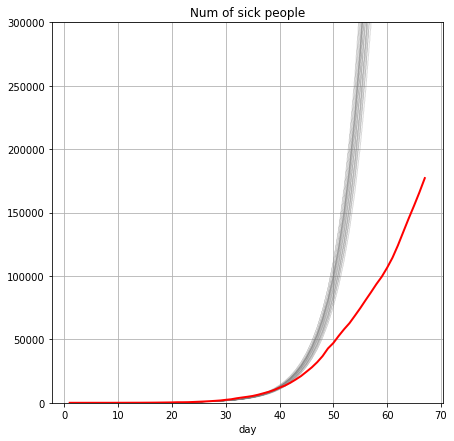

In [95]:
myplot_sample_lines(df)

In [65]:
df[df['nday'].isin([15, 30, 60])][['nday', 'total_cases']]

,nday,total_cases
14,15,93
29,30,2337
59,60,106498


In [60]:
ans = np.exp(np.mean(ex['y_new'], axis=0))[[15, 30, 60]]
print("На 15й день = %.0f, на 30й = %.0f, на 60й = %.0f" % (ans[0], ans[1], ans[2]))

На 15й день = 93, на 30й = 1952, на 60й = 867249


В прошлом ноутбуке получали аналогичные значения

> day = 15, prediction = 70

> day = 30, prediction = 1520

> day = 60, prediction = 846909

#### Воспользовались небольшой магией и получили схожие результаты :)